# ModVege results - Moorepark time series distribution

In [1]:
# import libraries
import os
import glob
import itertools
import numpy as np
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from dask.distributed import Client
import climag.plot_configs as cplt
import climag.plot_facet_maps as cfacet

In [2]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-04-26 12:30:30.508837+00:00


In [3]:
client = Client(n_workers=2, threads_per_worker=4, memory_limit="3GB")

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 5.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38511,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 5.59 GiB
Comm: tcp://127.0.0.1:42471,Total threads: 4
Dashboard: http://127.0.0.1:35827/status,Memory: 2.79 GiB
Nanny: tcp://127.0.0.1:35797,


In [5]:
# Moorepark met station coords
LON, LAT = -8.26389, 52.16389

In [6]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries.gpkg")
ie_bbox = gpd.read_file(GPKG_BOUNDARY, layer="ne_10m_land_2157_IE_BBOX_DIFF")

In [7]:
BASE_DIR = os.path.join("data", "ModVege", "EURO-CORDEX")
TEMP_DIR = os.path.join(BASE_DIR, "stats")
os.makedirs(TEMP_DIR, exist_ok=True)

In [8]:
# exp, model = "rcp45", "EC-EARTH"

In [14]:
datasets = {}

for exp, model, data in itertools.product(
    ["historical", "rcp45", "rcp85"],
    ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"],
    ["EURO-CORDEX", "HiResIreland"]
):
    # auto-rechunking may cause NotImplementedError with object dtype
    # where it will not be able to estimate the size in bytes of object data
    if model == "HadGEM2-ES":
        CHUNKS = 300
    else:
        CHUNKS = "auto"

    datasets[f"{data}_{model}_{exp}"] = xr.open_mfdataset(
        glob.glob(
            os.path.join(
                "data", "ModVege", data, exp, model,
                f"*{data}*{model}*{exp}*.nc"
            )
        ),
        chunks=CHUNKS,
        decode_coords="all"
    )

    # convert HadGEM2-ES data back to 360-day calendar
    # this ensures that the correct weighting is applied when calculating
    # the weighted average
    if model == "HadGEM2-ES":
        datasets[f"{data}_{model}_{exp}"] = (
            datasets[f"{data}_{model}_{exp}"].convert_calendar(
                "360_day", align_on="year"
            )
        )

# remove spin-up year
for key in datasets.keys():
    if "historical" in key:
        datasets[key] = datasets[key].sel(time=slice("1976", "2005"))
    else:
        datasets[key] = datasets[key].sel(time=slice("2041", "2070"))
    # # normalise to keep only date in time
    # datasets[key]["time"] = datasets[key].indexes["time"].normalize()

In [15]:
list(datasets.keys())

['EURO-CORDEX_CNRM-CM5_historical',
 'HiResIreland_CNRM-CM5_historical',
 'EURO-CORDEX_EC-EARTH_historical',
 'HiResIreland_EC-EARTH_historical',
 'EURO-CORDEX_HadGEM2-ES_historical',
 'HiResIreland_HadGEM2-ES_historical',
 'EURO-CORDEX_MPI-ESM-LR_historical',
 'HiResIreland_MPI-ESM-LR_historical',
 'EURO-CORDEX_CNRM-CM5_rcp45',
 'HiResIreland_CNRM-CM5_rcp45',
 'EURO-CORDEX_EC-EARTH_rcp45',
 'HiResIreland_EC-EARTH_rcp45',
 'EURO-CORDEX_HadGEM2-ES_rcp45',
 'HiResIreland_HadGEM2-ES_rcp45',
 'EURO-CORDEX_MPI-ESM-LR_rcp45',
 'HiResIreland_MPI-ESM-LR_rcp45',
 'EURO-CORDEX_CNRM-CM5_rcp85',
 'HiResIreland_CNRM-CM5_rcp85',
 'EURO-CORDEX_EC-EARTH_rcp85',
 'HiResIreland_EC-EARTH_rcp85',
 'EURO-CORDEX_HadGEM2-ES_rcp85',
 'HiResIreland_HadGEM2-ES_rcp85',
 'EURO-CORDEX_MPI-ESM-LR_rcp85',
 'HiResIreland_MPI-ESM-LR_rcp85']

In [16]:
datasets["EURO-CORDEX_EC-EARTH_rcp45"]

<xarray.Dataset>
Dimensions:       (rlat: 33, rlon: 37, time: 10957, bnds: 2)
Coordinates:
    lat           (rlat, rlon) float64 dask.array<chunksize=(33, 37), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(33, 37), meta=np.ndarray>
  * rlat          (rlat) float64 3.685 3.795 3.905 4.015 ... 6.985 7.095 7.205
  * rlon          (rlon) float64 -17.27 -17.16 -17.05 ... -13.53 -13.41 -13.3
  * time          (time) datetime64[ns] 2041-01-01T12:00:00 ... 2070-12-31T12...
    height        float64 2.0
    rotated_pole  |S1 b''
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    spatial_ref   int64 0
Dimensions without coordinates: bnds
Data variables: (12/24)
    bm_gv         (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    bm_gr         (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    bm_dv         (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    bm_dr         (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    age_gv        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    age_gr        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    ...            ...
    sen_gv        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    sen_gr        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    abs_dv        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    abs_dr        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    omd_gv        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    omd_gr        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
Attributes:
    creation_date:  2023-03-11 00:11:26.834262+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_EURO-CORDEX_RCA4_EC-EARTH_rcp45

In [17]:
varlist = ["bm", "pgro", "gro", "i_bm"]

## Box plots

In [18]:
data_all = cplt.boxplot_data(
    datasets=datasets, varlist=varlist, lonlat=(LON, LAT)
)

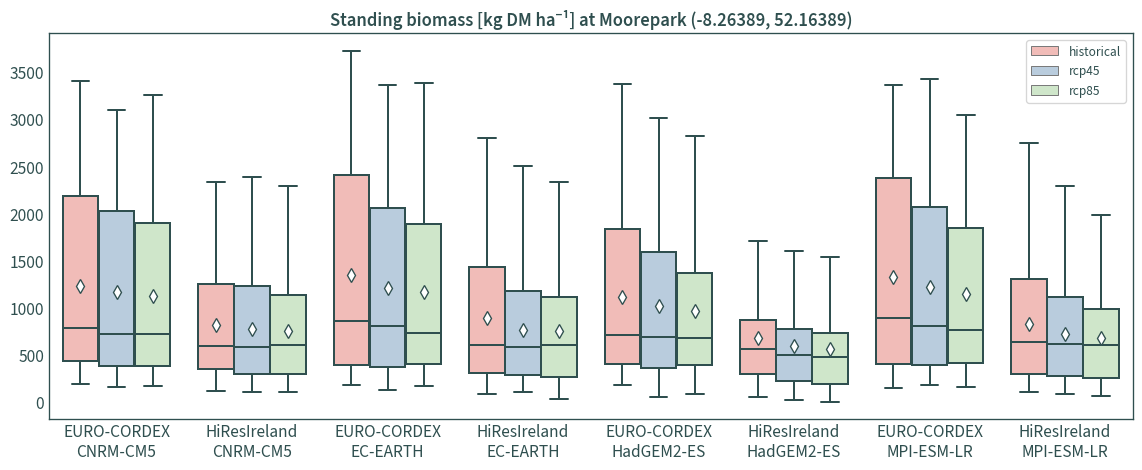

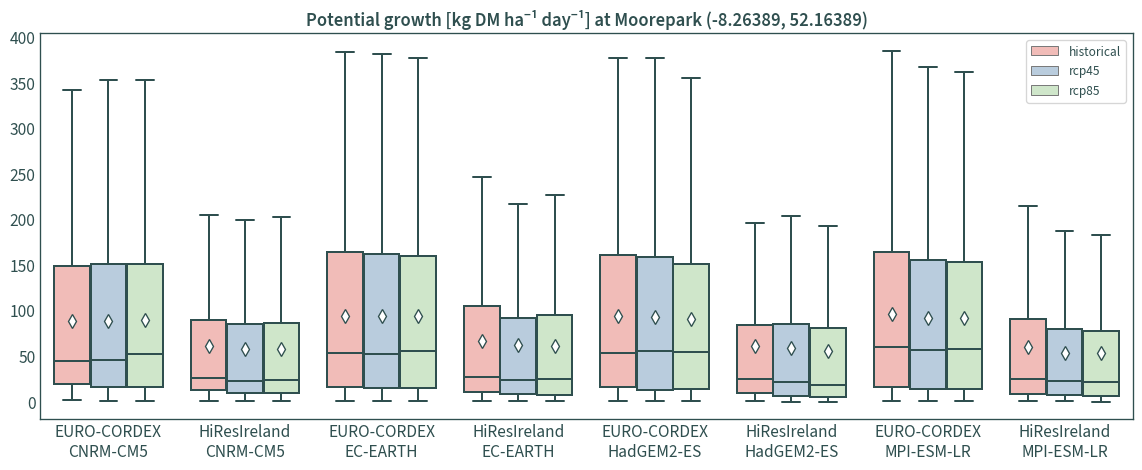

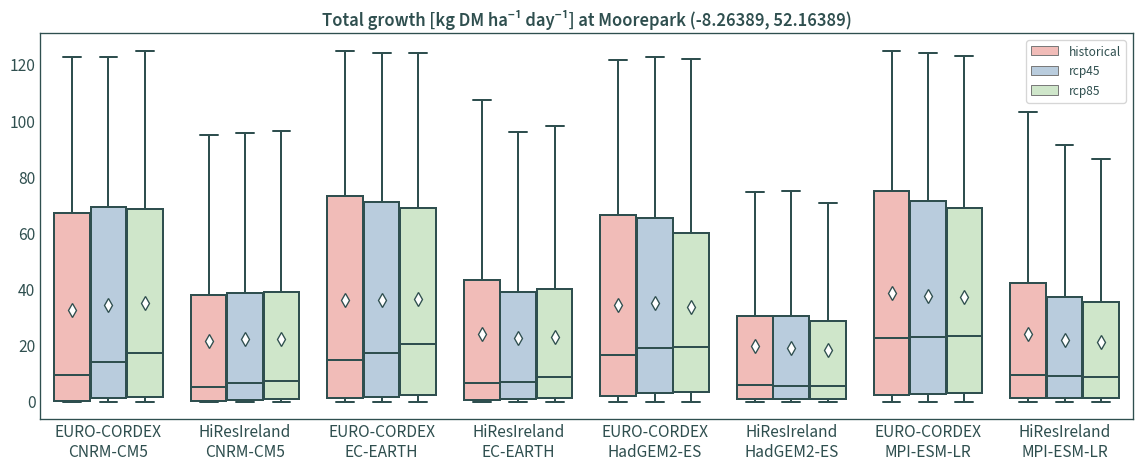

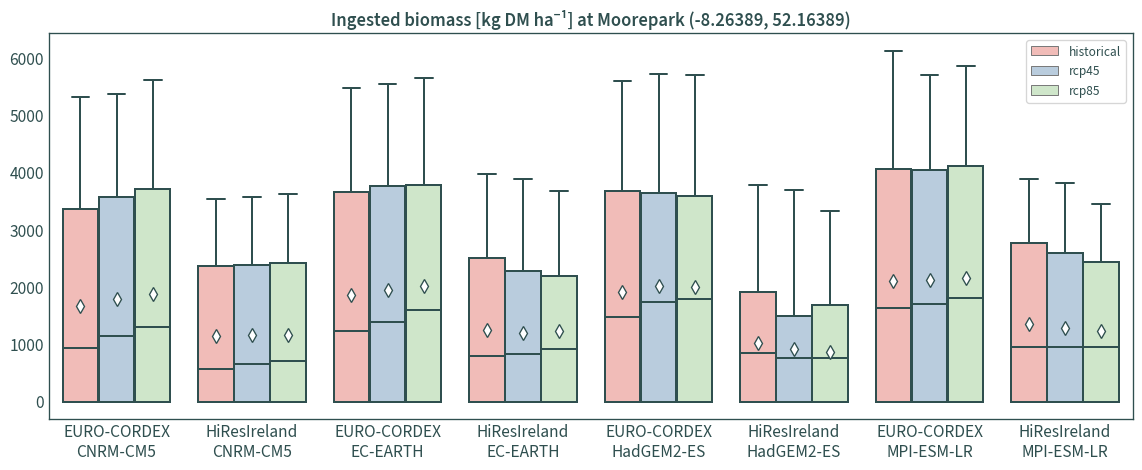

In [19]:
for var in varlist:
    cplt.boxplot_all(
        data=data_all[var],
        var=var,
        title=(
            datasets["EURO-CORDEX_EC-EARTH_rcp45"][var].attrs["long_name"] +
            f" [{datasets['EURO-CORDEX_EC-EARTH_rcp45'][var].attrs['units']}]"
            f" at Moorepark ({LON}, {LAT})"
        )
    )

## Histograms

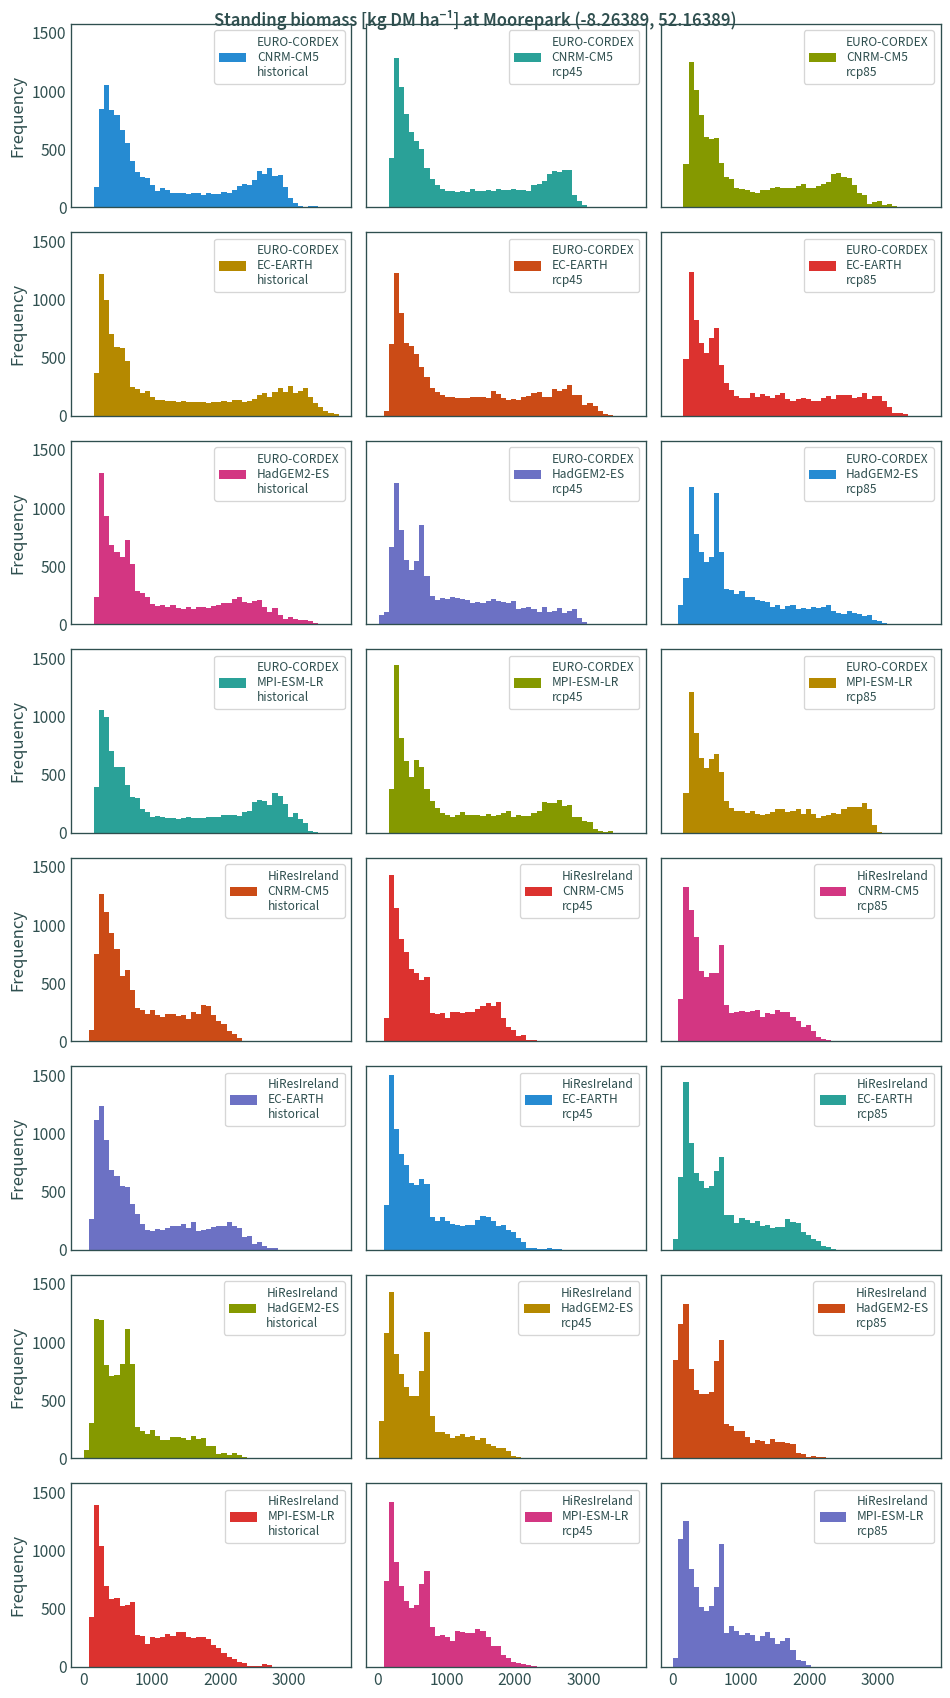

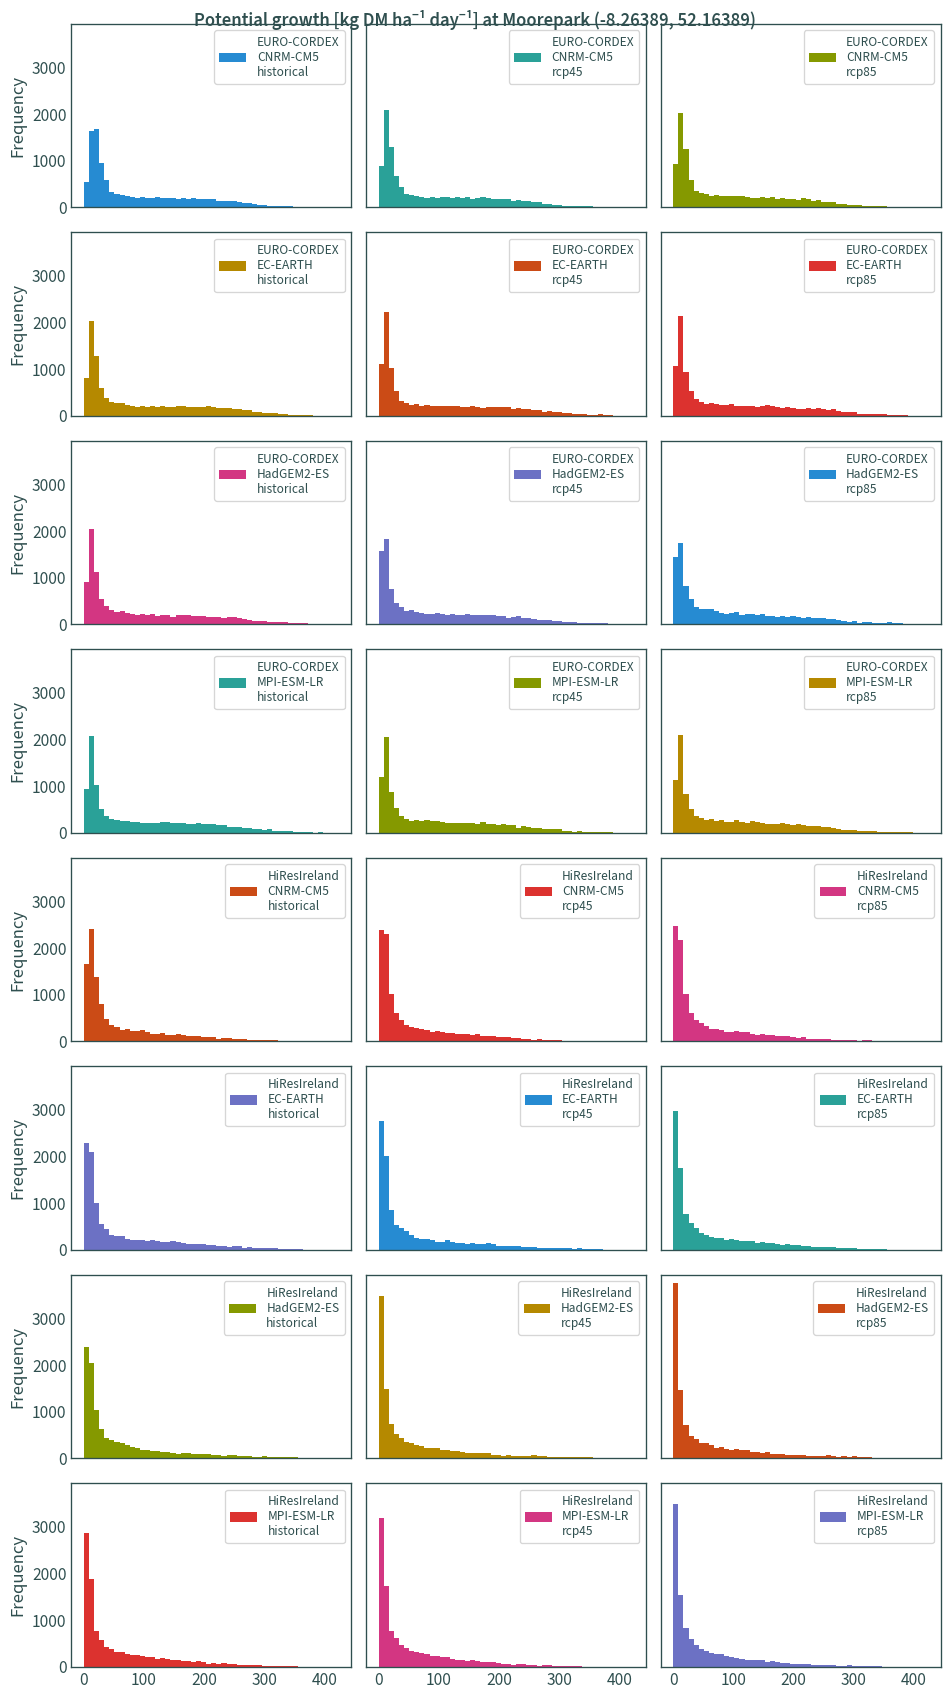

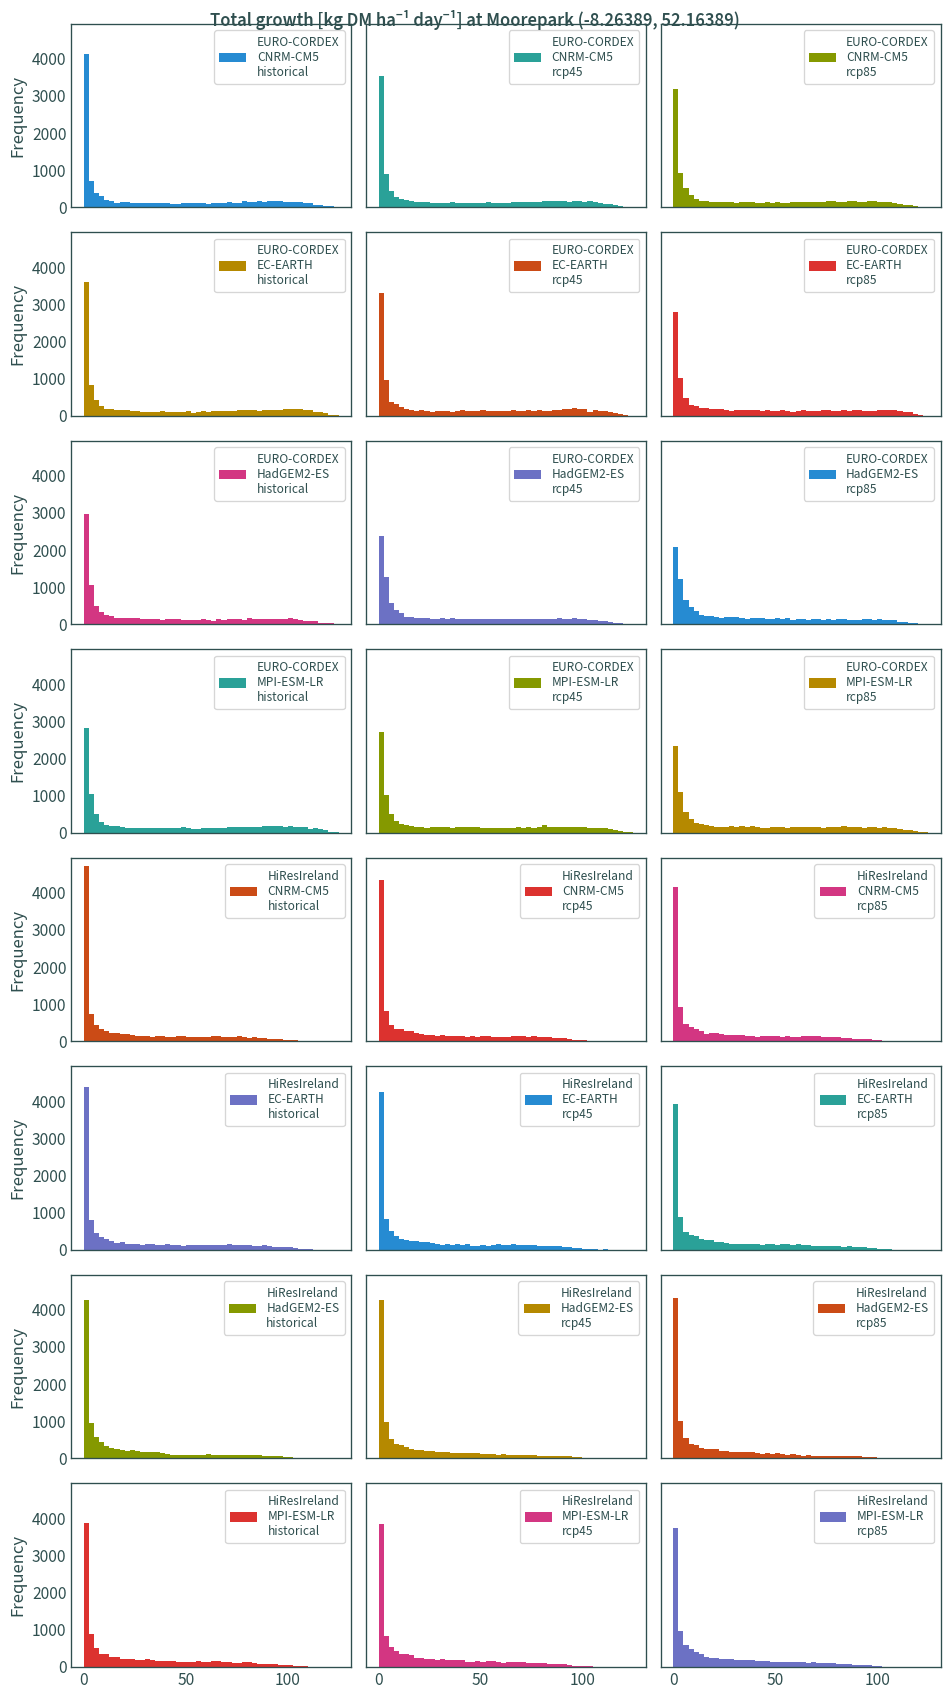

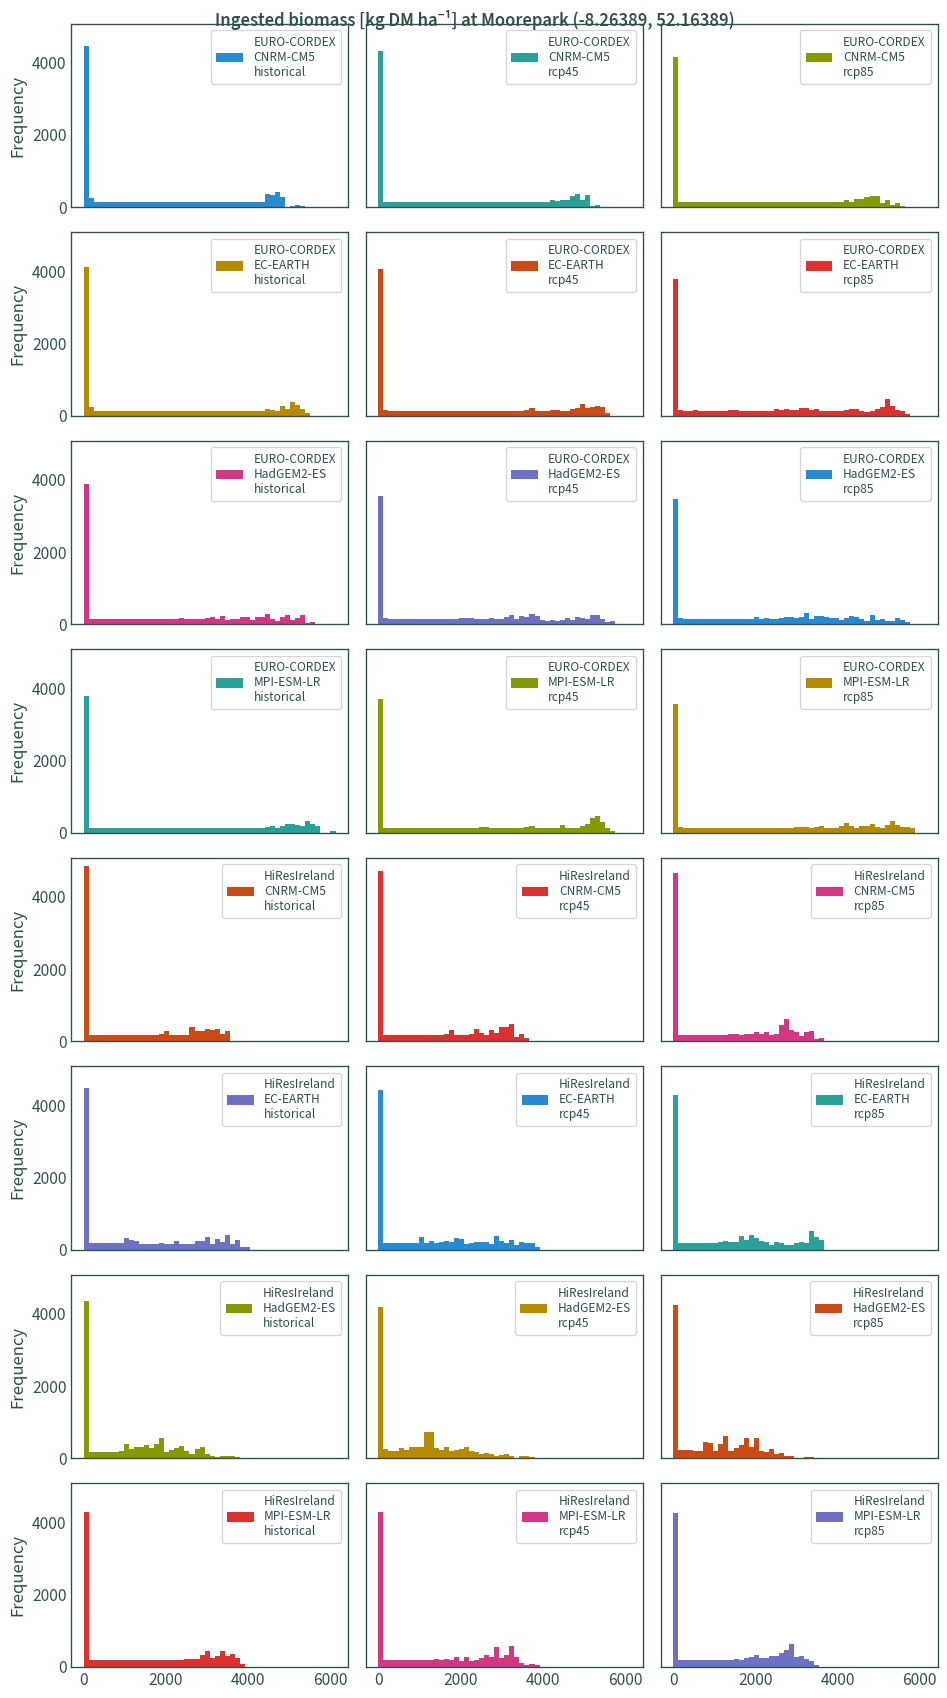

In [22]:
for var in varlist:
    data_pivot = pd.pivot_table(
        data_all[var], values=var, columns="legend",
        index=data_all[var].index
    )
    data_pivot.plot(
        kind="hist", subplots=True, figsize=(10, 18), bins=50, sharex=True,
        sharey=True, layout=(8, 3),
        title=(
            datasets["EURO-CORDEX_EC-EARTH_rcp45"][var].attrs["long_name"] +
            f" [{datasets['EURO-CORDEX_EC-EARTH_rcp45'][var].attrs['units']}]"
            f" at Moorepark ({LON}, {LAT})"
        )
    )
    plt.tight_layout()
    plt.show()